In [1]:
!pip install -U torch

    100% |████████████████████████████████| 676.9MB 92kB/s  eta 0:00:01    25% |████████▏                       | 172.8MB 62.1MB/s eta 0:00:09    30% |██████████                      | 209.6MB 72.4MB/s eta 0:00:07       | 218.9MB 69.9MB/s eta 0:00:07    35% |███████████▍                    | 242.0MB 54.8MB/s eta 0:00:08    40% |████████████▉                   | 272.0MB 64.0MB/s eta 0:00:07    45% |██████████████▊                 | 310.4MB 68.4MB/s eta 0:00:06    46% |███████████████                 | 316.7MB 69.2MB/s eta 0:00:06    48% |███████████████▍                | 325.8MB 58.7MB/s eta 0:00:06    53% |█████████████████               | 360.9MB 66.6MB/s eta 0:00:05    53% |█████████████████▏              | 364.1MB 58.5MB/s eta 0:00:06[K    55% |█████████████████▉              | 376.4MB 80.8MB/s eta 0:00:04    56% |██████████████████              | 379.6MB 61.7MB/s eta 0:00:05    62% |███████████████████▉            | 420.6MB 63.4MB/s eta 0:00:05    64% |████████████████████▌        

In [2]:
import numpy as np
import torch

from torch import nn
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [3]:
import utils
import models
import trainer
import mclnn

In [4]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data=True

In [5]:
conf.columns, conf.column_encoder = utils.read_columns()

In [6]:
all_x, all_y, _ = torch.load("./train_curated_preprocessed.tc")
# all_x, all_y, _ = utils.read_dataset("./data/train_curated", conf, lambda s: utils.audio_to_melspectrogram(conf, s))

In [7]:
np.random.seed(42)
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.1)

In [8]:
train_dataset = trainer.SoundDataset(train_x, train_y)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [124]:
model = nn.Sequential(
    mclnn.CLNNModule(128, 256, 4),
    nn.LeakyReLU(),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4),
    nn.LeakyReLU(),
#     nn.MaxPool1d(4),
    mclnn.TemporalPool(2),
    mclnn.CLNNModule(256, 256, 4),
    nn.LeakyReLU(),
    mclnn.TemporalPool(4),
    mclnn.BatchNorm(256),
    mclnn.Flatten(),
    nn.Linear(256*8, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, len(conf.columns))
)

In [125]:
model(b['x']).shape

torch.Size([64, 80])

In [126]:
device = torch.device("cuda")

model = model.to(device)

In [127]:
tr = trainer.Trainer(model, torch.optim.Adam, device, {"path":"./experiments/lstm/"})

In [ ]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":100, "grad_clip_norm":10.0, "validate_every":25},
)

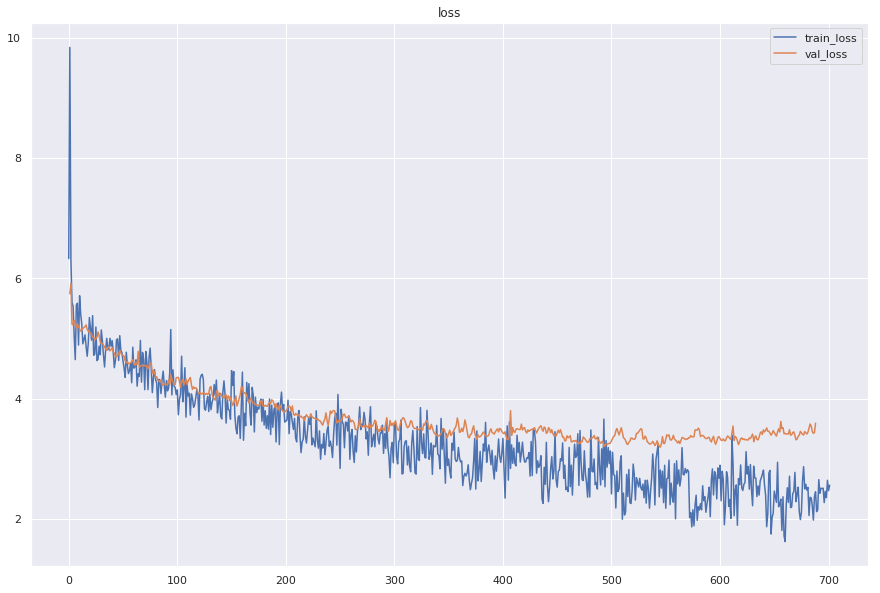

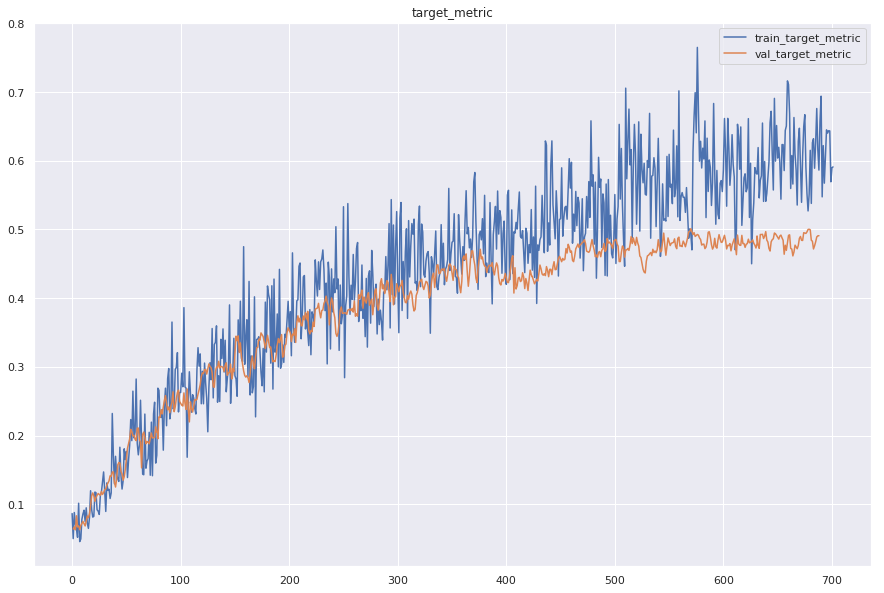

In [39]:
tr.plot(tr.train_metrics, tr.val_metrics)